In [8]:
import pandas as pd
import numpy as np
import string

In [9]:
df = pd.read_csv('/Users/sam/Desktop/github-assignment/inte_stab_fair/explainable-credit-scoring/dataproject2025.csv')
df = df.dropna()

In [10]:
X_cols = ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length',
       'emp_title', 'fico_range_high', 'funded_amnt', 'grade',
       'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'revol_bal', 'revol_util', 'sub_grade',
       'tax_liens', 'zip_code', 'Pct_afro_american']

y = df['Predictions']

In [11]:
numerical = ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'fico_range_high', 'funded_amnt', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'tax_liens', 'zip_code', 'Pct_afro_american']

In [12]:
category = ['emp_length',
       'emp_title',
       'grade',
       'home_ownership',
       'purpose',
       'sub_grade',
       ]

In [13]:
X = df[X_cols]

In [14]:
#FIXME - this should technically be an import from utils.py
def categorical_encoding(df: pd.DataFrame) -> pd.DataFrame:
  """Encodings of categorical variables."""

  df_encoded = df.copy()

  # grade to numeric
  grade_map = {c: i+1 for i, c in enumerate(string.ascii_uppercase[:7])}
  df_encoded["grade_num"] = df_encoded["grade"].map(grade_map)

  # sub_grade to numeric
  sg = df_encoded["sub_grade"].astype(str).str.upper().str.strip()
  letter = sg.str[0]
  number = pd.to_numeric(sg.str[1:].str.extract(r"(\d+)", expand=False), errors="coerce")
  letter_map = {ch: i+1 for i, ch in enumerate("ABCDEFG")}
  base = letter.map(letter_map)
  sub_grade_num = (base - 1) * 5 + number
  df_encoded["sub_grade_num"] = sub_grade_num.astype("float32")

  # emp_length to numeric; map prob cleanest; maybe 10+ different?
  emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
  }

  df_encoded["emp_length_num"] = df_encoded["emp_length"].map(emp_length_map).astype("float32")

  # one-hot
  onehot_cols = ["home_ownership", "purpose", "emp_title"]
  df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, prefix=onehot_cols, drop_first=True)

  # drop originals
  df_encoded = df_encoded.drop(columns=["grade", "sub_grade", "emp_length"])

  return df_encoded

In [15]:
X_encoded = categorical_encoding(X)

In [16]:
X_encoded.shape, y.shape

((597973, 96), (597973,))

## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression


In [18]:
logreg = LogisticRegression(max_iter=3000, solver='newton-cholesky')
logreg.fit(X_encoded, y)

/Users/sam/Desktop/github-assignment/inte_stab_fair/test_cred/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:591: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.6935e-18): result may not be accurate.
  warnings.warn(
/Users/sam/Desktop/github-assignment/inte_stab_fair/test_cred/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:197: ConvergenceWarning: lbfgs failed to converge after 2999 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2999).
You might also want to scale

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cholesky'
,max_iter,3000
,multi_class,'deprecated'


In [19]:
df['surrogate_preds_proba'] = logreg.predict_proba(X_encoded)[:, 1] #probs of 1
df['surrogate_preds'] = logreg.predict(X_encoded)

## Evaluating the surrogate

In [20]:
from sklearn.metrics import accuracy_score, mean_squared_error, auc, roc_curve, confusion_matrix

In [21]:
fpr, tpr, thresholds = roc_curve(df['Predictions'], df['surrogate_preds'])

In [22]:
auc(fpr, tpr), df.Predictions.value_counts()

(0.861679595735013,
 Predictions
 0.0    466532
 1.0    131441
 Name: count, dtype: int64)

In [23]:
accuracy_score(df['Predictions'], df['surrogate_preds'])

0.9146901281495987

In [24]:
confusion_matrix(df['Predictions'], df['surrogate_preds'])

array([[446134,  20398],
       [ 30615, 100826]])

In [25]:
mean_squared_error(df['Predicted probabilities'], df['surrogate_preds_proba']) # 5% off

0.05866937407699177

## Interpreting the model

In [26]:
df_or = pd.DataFrame({
    'feature': X_encoded.columns,
    'coeff': logreg.coef_[0],
    'odds_ratio': np.exp(logreg.coef_[0])
})

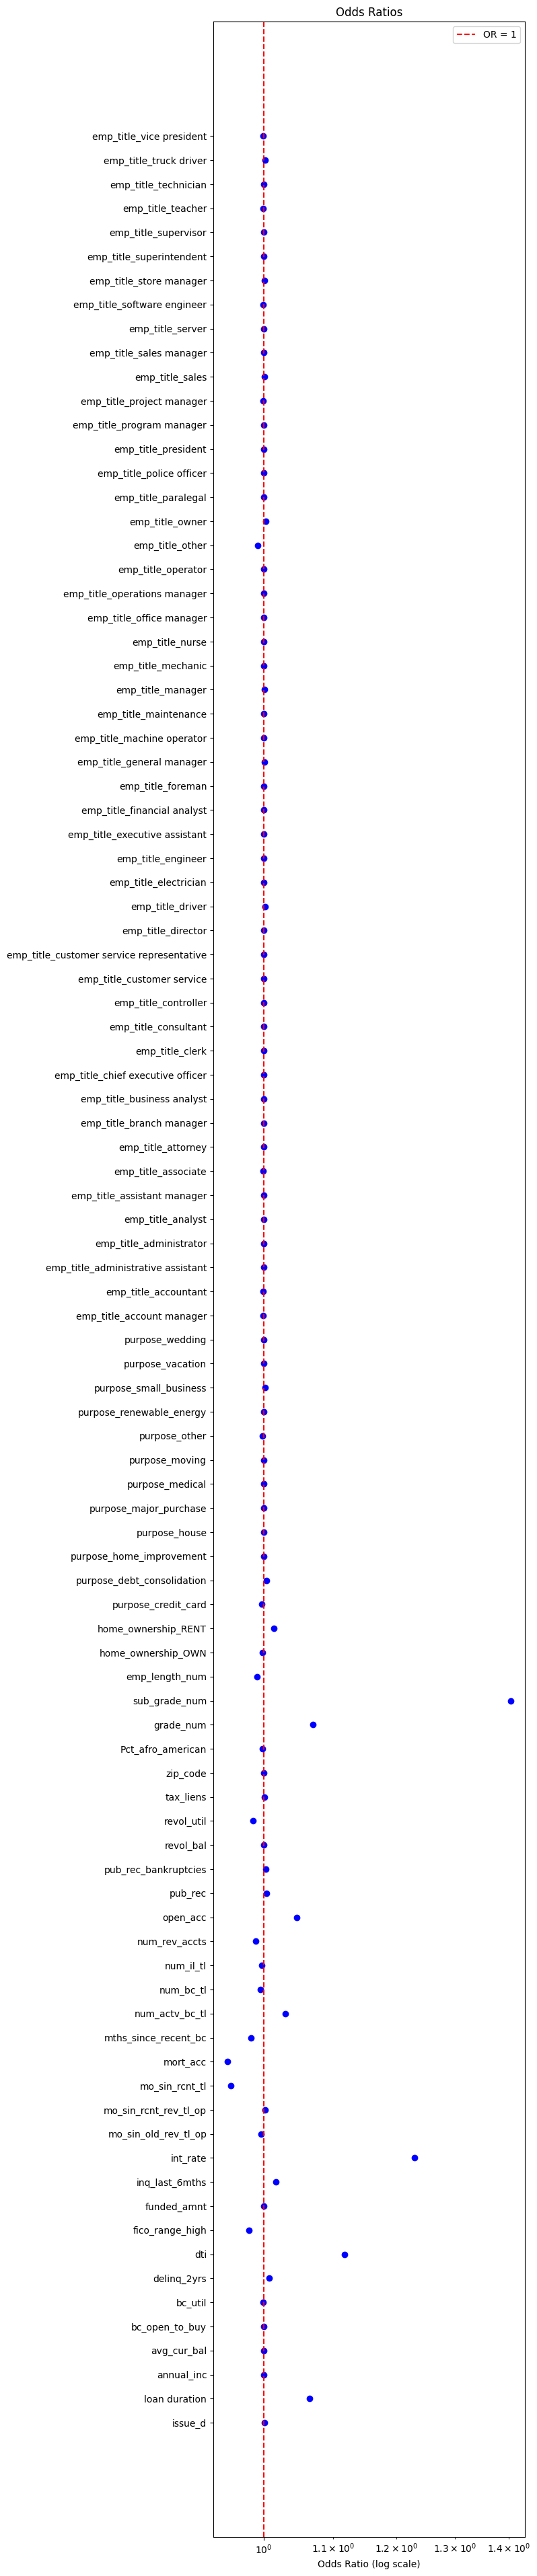

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Prepare data
summary = df_or
plt.figure(figsize=(8, len(summary) * 0.4))
plt.scatter(summary['odds_ratio'], summary['feature'], color='blue')
plt.axvline(x=1, color='red', linestyle='--', label='OR = 1')
plt.xscale('log')
plt.xlabel('Odds Ratio (log scale)')
plt.title('Odds Ratios')
plt.legend()
plt.tight_layout()
plt.show()






## Custom PLTR

In [28]:
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
import pandas as pd


class PLTR(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=80, max_depth=2, random_state=None, granularity=2):
        self.granularity = granularity #how much the rounding should be
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees_ = []

    def tree_fit(self, X, y):
        self.trees_ = []
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=None if self.random_state is None else self.random_state + i
            )
            tree.fit(X, y)
            self.trees_.append(tree)
        return self

    def tree_predict(self, X):
        preds = [tree.predict(X) for tree in self.trees_]
        return sum(preds) / len(preds)

    def identify(self, k=5, feature_names=None):
        """
        Identify the most common (root split, child split) pairs across trees.

        Parameters
        ----------
        k : int
            Number of most common split pairs to return.
        feature_names : list, optional
            Names of features. If None, indices are returned.
        """
        pair_counter = Counter()

        for tree in self.trees_:
            t = tree.tree_

            # Root node
            

            if t.feature[0] != -2:  # -2 means leaf
                f_root = t.feature[0]
                thr_root = round(t.threshold[0], self.granularity)
                f_root_name = feature_names[f_root] if feature_names is not None else f_root

                # Look at children
                for child in [t.children_left[0], t.children_right[0]]:
                    if child != -1 and t.feature[child] != -2:
                        f_child = t.feature[child]
                        thr_child = round(t.threshold[child], self.granularity)
                        f_child_name = feature_names[f_child] if feature_names is not None else f_child

                        pair_counter[((f_root_name, thr_root), (f_child_name, thr_child))] += 1

        self.pairs_identified = pair_counter.most_common(k)
        self.pairs_identified = [pair for pair, count in self.pairs_identified]
        return self.pairs_identified
    

    def create_binary_vars(self, X, split_pairs, feature_names=None):
        """
        Create binary variables from root-child split pairs.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.
        split_pairs : list of tuples
            Each element is ((root_feature, root_thr), (child_feature, child_thr)).
        feature_names : list, optional
            Names of features. If None, indices are used.
            
        Returns
        -------
        df_bin : pd.DataFrame
            DataFrame with 2 binary variables per pair.
        """
        X = np.array(X)
        n_samples = X.shape[0]
        df_bin = pd.DataFrame()
        
        for i, ((f_root, thr_root), (f_child, thr_child)) in enumerate(split_pairs):
            # Get feature indices if names are provided
            f_root_idx = feature_names.index(f_root) if feature_names else f_root
            f_child_idx = feature_names.index(f_child) if feature_names else f_child
            
            # Binary var 1: root split
            bin1 = (X[:, f_root_idx] > thr_root).astype(int)
            
            # Binary var 2: child split only where bin1 == 0
            bin2 = np.zeros(n_samples, dtype=int)
            mask = bin1 == 0
            bin2[mask] = (X[mask, f_child_idx] > thr_child).astype(int)
            
            df_bin[f"pair{i}_root"] = bin1
            df_bin[f"pair{i}_child"] = bin2
        
        self.modified_df = df_bin
        return self.modified_df

    def fit(self, X, y):
        self.pltr = LogisticRegression()
        self.tree_fit(X,y)
        self.identify(k=5)
        self.create_binary_vars(X, self.pairs_identified)
        self.pltr.fit(self.modified_df, y)
        return self
    
    def predict(self, X):
        return self.pltr.predict(X)


In [31]:
pltr = PLTR()
pltr.fit(X_encoded, y)

,n_estimators,80
,max_depth,2
,random_state,None
,granularity,2


In [33]:
pltr_pred = pltr.predict(pltr.modified_df)

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, auc, roc_curve, confusion_matrix

In [34]:
fpr, tpr, thresholds = roc_curve(df['Predictions'], pltr_pred)

In [35]:
auc(fpr, tpr), df.Predictions.value_counts()

(0.8478006457537718,
 Predictions
 0.0    466532
 1.0    131441
 Name: count, dtype: int64)

In [37]:
accuracy_score(df['Predictions'], pltr_pred)

0.8705744239288395

In [38]:
confusion_matrix(df['Predictions'], pltr_pred)

array([[414486,  52046],
       [ 25347, 106094]])